In [1]:
%matplotlib notebook

In [2]:
import warnings

with warnings.catch_warnings():
    # Hide messy warnings
    warnings.simplefilter('ignore')
    
    import os, sys, inspect

    current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parent_dir = os.path.dirname(current_dir)
    sys.path.insert(0,parent_dir)

    ## Keras for deep learning## Kera 
    from keras.layers.core import Dense, Activation, Dropout
    from keras.layers.recurrent import LSTM
    from keras.layers import Bidirectional
    from keras.models import Sequential

    ## Scikit learn for mapping metrics
    from sklearn.metrics import mean_squared_error

    #for logging
    import time

    ##matrix math
    import numpy as np
    import math

    ##plotting
    import matplotlib.pyplot as plt

    ##data processing
    import pandas as pd
    
    # Notebook progress bars
    from ipywidgets import IntProgress, HTML, HBox
    from IPython.display import display

Using TensorFlow backend.


In [3]:
# TODO: this is just sequence_length - input_length
PREDICTION_LENGTH = 10 # number of timesteps to predict ahead to

df = pd.read_csv('../data/BCCUSDT.csv', header=0, index_col='trade_time',
                 names= ['event_time', # E
                         'ignore', # M
                         'trade_time', # T
                         'seller_order_id', # a
                         'buyer_order_id', # b
                         'event_type', # e
                         'is_buyer_maker', # m
                         'price', # p
                         'quantity', # q
                         'symbol', # s
                         'trade_id' # t
                        ])

price_col = 'price'

# drop useless columns
df = df.drop(columns=['buyer_order_id','seller_order_id','event_time','ignore','symbol','trade_id','event_type'])

# format data
df.index = pd.to_datetime(df.index, unit='ms')
df['price'] = df['price'].values
df['quantity'] = df['quantity'].values

# map strings to boolean values
df['is_buyer_maker'] = df['is_buyer_maker'].map({' False': -1, ' True': 1})

df = df.dropna()
df[:10]

,is_buyer_maker,price,quantity
trade_time,,,
2018-02-09 22:01:35.332,-1,1278.84,0.03879
2018-02-09 22:01:38.225,1,1278.84,0.19120
2018-02-09 22:01:39.675,1,1278.84,0.92646
2018-02-09 22:02:09.321,-1,1278.84,0.00154
2018-02-09 22:02:09.321,-1,1278.84,0.02794
2018-02-09 22:02:28.628,-1,1278.84,0.15000
2018-02-09 22:02:31.987,1,1274.78,0.02082
2018-02-09 22:02:31.987,1,1274.42,0.05915
2018-02-09 22:02:47.624,1,1275.25,0.08280


In [4]:
# feature engineering

#df['sma_20'] = df[price_col].rolling(window=20, center=False).mean()
#df['std_20'] = df[price_col].rolling(window=20,center=False).std()
#df['price_deviation'] = (df[price_col] - df['sma_20']) / df['std_20']

In [5]:
# drop any samples with NaN
df = df.dropna()
df.head()

,is_buyer_maker,price,quantity
trade_time,,,
2018-02-09 22:01:35.332,-1,1278.84,0.03879
2018-02-09 22:01:38.225,1,1278.84,0.19120
2018-02-09 22:01:39.675,1,1278.84,0.92646
2018-02-09 22:02:09.321,-1,1278.84,0.00154
2018-02-09 22:02:09.321,-1,1278.84,0.02794


<IPython.core.display.Javascript object>


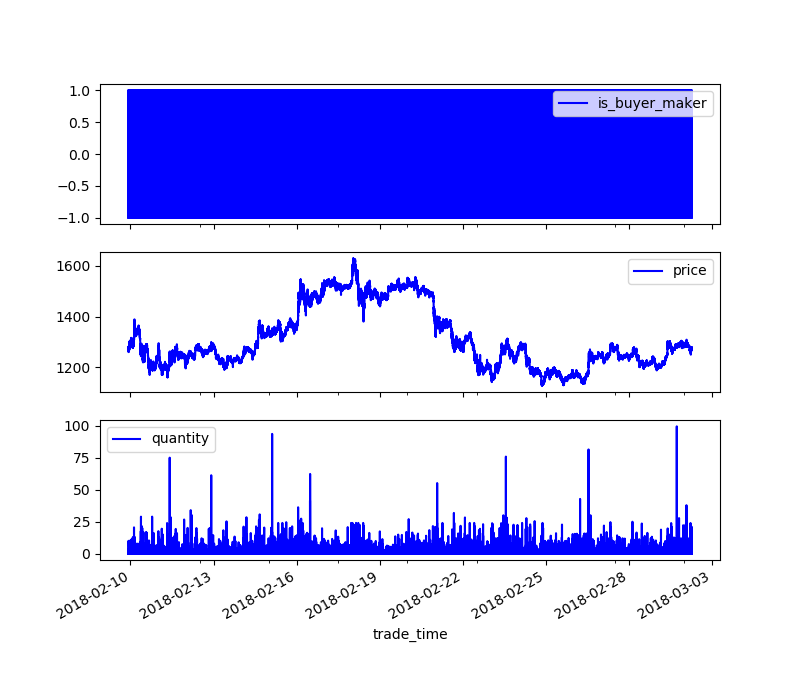

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f99e6e4e0>,
      dtype=object)

In [6]:
df.plot(subplots=True,style='b',figsize=(8,7))

In [7]:
df.columns

Index(['is_buyer_maker', 'price', 'quantity'], dtype='object')

In [8]:
### FUNCTION PARAMETERS ###
input_length = 50 # TUAN: use this so our input is 50 timesteps
sequence_length = 60 # use this so we predict the end of the normalized sequence, which is 70 timesteps
###########################

PRICE_COLUMN = int(list(df.columns).index('price'))
print('PRICE_COLUMN:', PRICE_COLUMN)
#SMA_COLUMN = int(list(df.columns).index('sma_20'))

raw_data = df.values

# propagate last valid observations to fill zeros
# TODO: I don't think this is necessary
#for x in range(0, raw_data.shape[0]):
#        for y in range(0, raw_data.shape[1]):
#            if(raw_data[x][y] == 0):
#                raw_data[x][y] = raw_data[x-1][y]

data = list(raw_data)

PRICE_COLUMN: 1


In [9]:
# progress bar
max_count = int(len(data) - sequence_length)
progress = IntProgress(value=0, min=0, max=max_count, step=1, description='Sequences:')
label = HTML()
box = HBox(children=[progress, label])
display(box)

# Convert dataframe to sequences for training input
sequences = []
for i in range(len(data) - sequence_length):
    sequences.append(data[i:i+sequence_length])
    
    #progress bar
    progress.value = i
    label.value = str('%i / %i' % (i, max_count-1))
unnormalized_seqs = np.array(sequences)

HBox(children=(IntProgress(value=0, description='Sequences:', max=577494), HTML(value='')))

In [10]:
# Normalizing data by going through each window
unnormalized_seqs = np.array(sequences)

#normalized_seqs = unnormalized_seqs.copy()
#dr[:,0,PRICE_COLUMN] = 0
#dr[:,1:,PRICE_COLUMN]  = d0[:,1:,PRICE_COLUMN] / d0[:,0:1,PRICE_COLUMN] - 1.0
#dr[:,1:,SMA_COLUMN]  = d0[:,1:,SMA_COLUMN] / d0[:,0:1,SMA_COLUMN] - 1.0

normalized_seqs = np.zeros_like(unnormalized_seqs)
normalized_seqs[:,:,:] = unnormalized_seqs[:,:,:] / unnormalized_seqs[:,-10:-9,:] - 1

normalized_seqs

array([[[ 0.00000000e+00,  3.60999498e-03, -5.05922812e-01],
        [-2.00000000e+00,  3.60999498e-03,  1.43535855e+00],
        [-2.00000000e+00,  3.60999498e-03,  1.08005350e+01],
        ...,
        [ 0.00000000e+00, -2.04827976e-03,  2.90317157e+01],
        [-2.00000000e+00, -3.32747363e-03,  2.73723093e-01],
        [ 0.00000000e+00, -3.32747363e-03,  5.00573175e-01]],

       [[ 0.00000000e+00,  5.07709961e-03,  3.98435871e+00],
        [ 0.00000000e+00,  5.07709961e-03,  2.31517205e+01],
        [-2.00000000e+00,  5.07709961e-03, -9.59854015e-01],
        ...,
        [ 0.00000000e+00, -1.87051038e-03,  1.60688217e+00],
        [-2.00000000e+00, -1.87051038e-03,  2.07116788e+00],
        [ 0.00000000e+00, -1.87051038e-03,  2.85714286e-01]],

       [[ 0.00000000e+00,  5.49593112e-03,  8.29061372e+00],
        [-2.00000000e+00,  5.49593112e-03, -9.84556759e-01],
        [-2.00000000e+00,  5.49593112e-03, -7.19815483e-01],
        ...,
        [-2.00000000e+00, -1.45457405e-03,

60


<IPython.core.display.Javascript object>


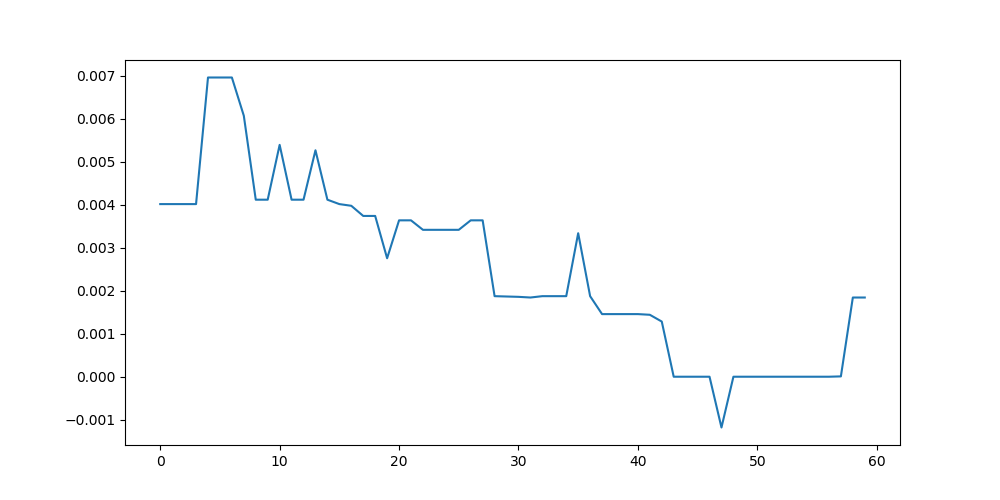

In [11]:
print(len(normalized_seqs[0]))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(normalized_seqs[15,:,PRICE_COLUMN])
plt.show()

60


<IPython.core.display.Javascript object>


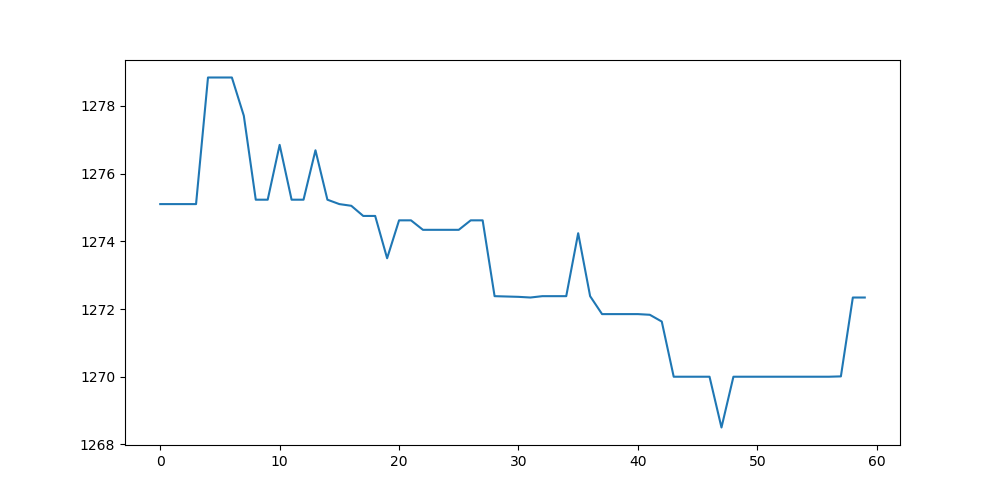

In [12]:
print(len(unnormalized_seqs[0]))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(unnormalized_seqs[15,:,PRICE_COLUMN])
plt.show()

In [13]:
target = normalized_seqs[:,(sequence_length-1),PRICE_COLUMN].reshape((normalized_seqs.shape[0],1))

# Splitting data into training and test sets
split_index = int(round(0.9 * normalized_seqs.shape[0]))
training_input = normalized_seqs[:split_index, :input_length]
testing_input = normalized_seqs[split_index:, :input_length]

training_output = target[:split_index]
testing_output = target[split_index:]

# Keeping the unnormalized prices for Y_test
# Useful when graphing price over time later
# TODO: there's probably a better way to do this
# TODO: I changed this to split_index instead of 2400
start = split_index
end = int(normalized_seqs.shape[0] + 1)
unnormalized_bases = unnormalized_seqs[start:end, 0:1, PRICE_COLUMN]


# Shuffle the data
# TODO: I think this is okay, but I should look into whether this affects performance of bidirectional
#np.random.shuffle(training_data)

# Training data
#X_train = training_input[:, :-1] # returns all but the last sample (trade) for each sequence (3D array)
X_train = training_input
Y_train = training_output

# Testing data
#X_test = testing_input[:, :-1] # returns all but the last sample (trade) for each sequence (3D array)
X_test = testing_input
Y_test = testing_output

# Get window size and sequence length
window_size = input_length

In [14]:
# STEP 2: BUILDING THE MODEL

### FUNCTION PARAMETERS ###
window_size = window_size
dropout_value = 0.15 # 15%
activation_function = 'linear'
loss_function = 'mse'
optimizer = 'adam'
###########################

model = Sequential()

# Fun fact: you only need to specify the input shape in the first layer
#First recurrent layer with dropout
#model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
model.add(LSTM(input_shape=(window_size, X_train.shape[-1]), units=50, return_sequences=True))
    # input shape is window_size (50) and number of columns
    # in this case, the model will take input arrays of shape (*, 50, 3)
model.add(Dropout(dropout_value))

#Second recurrent layer with dropout
#model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.6*dropout_value)) # TRY MODIFYING THIS

#Third recurrent layer
#model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(LSTM(50, return_sequences=False))

#Output layer (returns the predicted value)
model.add(Dense(units=1))
    # units=1 refers to the dimensionality of the output space
    # so the output is an array of shape (*, units), in this case (*, 1)

#Set activation function
model.add(Activation(activation_function))

#Set loss function and optimizer
model.compile(loss=loss_function, optimizer=optimizer)



print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total para

In [15]:
# STEP 3: TRAINING THE MODEL

### FUNCTION PARAMETERS ###
model = model
X_train = X_train
Y_train = Y_train
batch_num = 256 # batch size to be used
    # For inference (evaluate/predict), it is recommended to pick a batch size that is
    # as large as you can afford without going out of memory (since larger batches will
    # usually result in faster evaluating/prediction).
num_epoch = 3
val_split = .05 # use 5% of the input data for validation
###########################

start = time.time()

#Train the model on X_train and Y_train
model.fit(X_train, Y_train, batch_size=batch_num, epochs=num_epoch, validation_split=val_split)

#Get the time it took to train the model (in seconds)
training_time = int(math.floor(time.time() - start))

Train on 493757 samples, validate on 25988 samples
Epoch 1/3
493757/493757 [==============================] - 588s 1ms/step - loss: 2.8579e-05 - val_loss: 3.0344e-06
Epoch 2/3
493757/493757 [==============================] - 589s 1ms/step - loss: 3.4117e-06 - val_loss: 3.0123e-06
Epoch 3/3
493757/493757 [==============================] - 589s 1ms/step - loss: 3.2230e-06 - val_loss: 3.0860e-06


In [16]:
print('Training time: %s seconds' % str(training_time))

Training time: 1767 seconds


In [17]:
X_test

array([[[-2.00000000e+00,  2.29523458e-03, -8.65402931e-01],
        [-2.00000000e+00,  2.32733576e-03, -8.73386158e-01],
        [-2.00000000e+00,  2.33536106e-03, -9.92016773e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00, -9.86771787e-01],
        [ 0.00000000e+00,  0.00000000e+00,  4.29128525e+00],
        [ 0.00000000e+00,  0.00000000e+00, -9.75534420e-01]],

       [[-2.00000000e+00,  2.35146826e-03,  8.88732394e+01],
        [-2.00000000e+00,  2.35949375e-03,  4.66666667e+00],
        [-2.00000000e+00,  2.35949375e-03,  5.53661972e+01],
        ...,
        [ 0.00000000e+00,  2.40764669e-05,  3.75486854e+03],
        [ 0.00000000e+00,  2.40764669e-05,  1.63661972e+01],
        [ 0.00000000e+00,  2.40764669e-05,  7.08821596e+02]],

       [[-2.00000000e+00,  2.77797850e-03, -8.96837607e-01],
        [-2.00000000e+00,  2.77797850e-03,  2.61538462e-02],
        [-2.00000000e+00,  2.90643993e-03, -2.86837607e-01],
        ...,
        [ 0.00000000e+00,  4.41586178e-04,

<IPython.core.display.Javascript object>


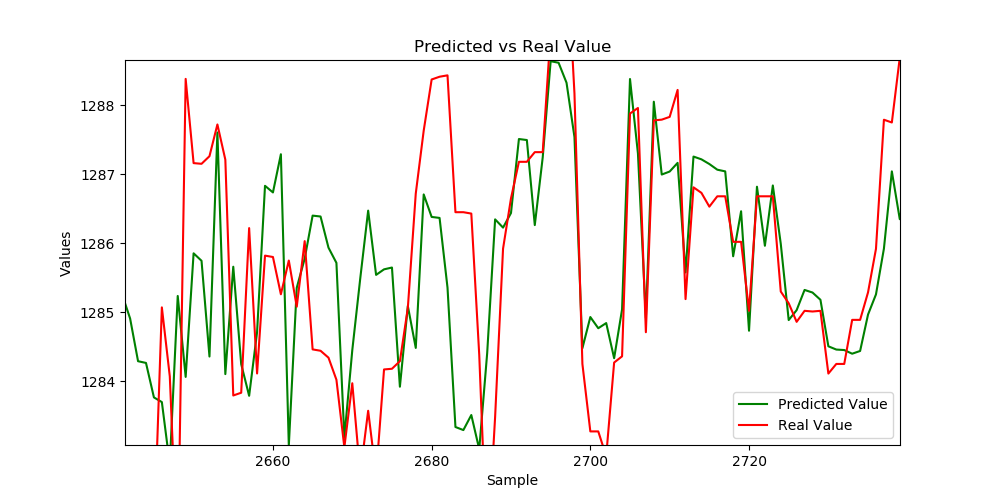

In [18]:
model=model
X_test=X_test
Y_test=Y_test
unnormalized_bases=unnormalized_bases

y_predict = model.predict(X_test)

#Create empty 2D arrays to store unnormalized values
real_y_test = np.zeros_like(Y_test)
real_y_predict = np.zeros_like(y_predict)

#Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
for i in range(Y_test.shape[0]): # i refers to the sequence
    predict = y_predict[i]
    real_y_predict[i] = (predict+1.0)*unnormalized_bases[i]

    y = Y_test[i]
    real_y_test[i] = (y+1.0)*unnormalized_bases[i]
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Predicted vs Real Value")
plt.plot(real_y_predict, color = 'green', label = 'Predicted Value')
plt.plot(real_y_test, color = 'red', label = 'Real Value')
ax.set_ylabel("Values")
ax.set_xlabel("Sample")
ax.legend()

plt.show(fig)

<IPython.core.display.Javascript object>


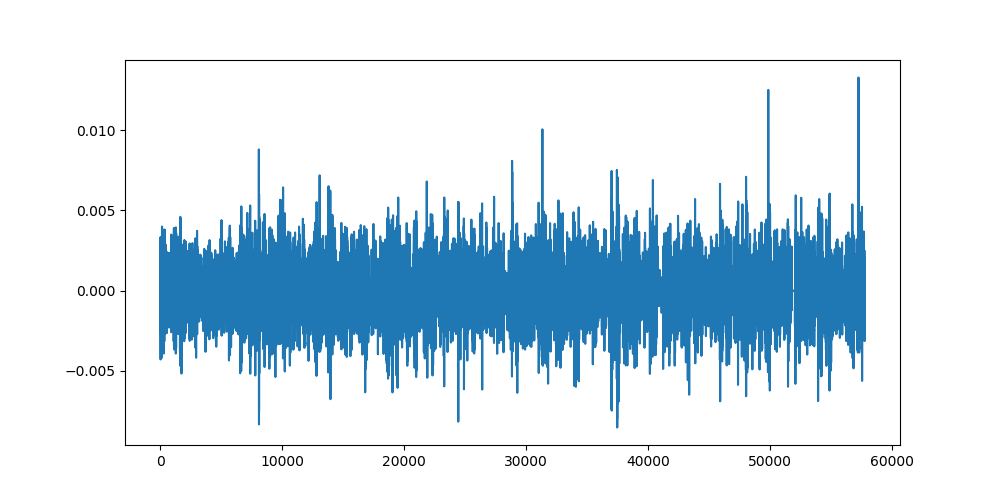

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(Y_test)
plt.show()

In [20]:
Y_test

array([[-0.00081055],
       [-0.0007865 ],
       [-0.00037736],
       ...,
       [ 0.00024278],
       [ 0.00024278],
       [ 0.00109641]])

In [21]:
model_json = model.to_json()

In [22]:
with open("BCCUSDT_model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
model.save_weights("BCCUSDT_model_weights.h5")